<a href="https://colab.research.google.com/github/Arindam75/Audio-Resnet/blob/main/L_Reduced_Resnet_RELU_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Add,Dense,Flatten,Dropout,Input,Activation,MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import resnet50
from tensorflow.keras import initializers
import pandas as pd
from tensorflow.keras.regularizers import l2

import numpy as np
import os
import datetime
import pandas as pd

In [ ]:
path='/content/drive/My Drive/Environmental'
path

'/content/drive/My Drive/Environmental'

In [ ]:
data = np.load(path+'/Training Data w Delta2.npz')
X_train=data['name1']
y_train=data['name2']

data = np.load(path+'/Validation Data w Delta2.npz')
X_val=data['name1']
y_val=data['name2']

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(24212, 13, 9, 2)
(24212, 10)
(71, 13, 9, 2)
(71, 10)


In [ ]:
X_train_mod=np.zeros([24212, 32, 32, 3])
X_val_mod=np.zeros([71, 32, 32, 3])

X_train_mod[::,0:13:,0:9:,0]=X_train[::,::,::,0]
X_val_mod[::,0:13:,0:9:,0]=X_val[::,::,::,0]

X_train_mod[::,0:13:,0:9:,1]=X_train[::,::,::,1]
X_val_mod[::,0:13:,0:9:,1]=X_val[::,::,::,1]

print(X_train_mod.shape)
print(y_train.shape)
print(X_val_mod.shape)
print(y_val.shape)

(24212, 32, 32, 3)
(24212, 10)
(71, 32, 32, 3)
(71, 10)


In [ ]:
def generator(X,y,batch_size):
  while True:
    samples=X.shape[0]
    batches=samples//batch_size
    
    for batch in range(0,batches):
        start=batch*batch_size
        stop=batch*batch_size+batch_size
        yield X[start:stop],y[start:stop]
    yield X[stop:],y[stop:]

In [ ]:
train_batch_size=32
val_batch_size=32
num_epochs=300

num_train_sequences=X_train_mod.shape[0]
num_val_sequences=X_val_mod.shape[0]

train_generator = generator(X_train_mod, y_train,train_batch_size)
val_generator = generator(X_val_mod, y_val, val_batch_size)

if (num_train_sequences%train_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/train_batch_size)
else:
    steps_per_epoch = (num_train_sequences//train_batch_size) + 1

if (num_val_sequences%val_batch_size) == 0:
    validation_steps = int(num_val_sequences/val_batch_size)
else:
    validation_steps = (num_val_sequences//val_batch_size) + 1

In [ ]:
my_model = resnet50.ResNet50(include_top=False, input_shape=(32,32,3))

flat = Flatten()(my_model.layers[-114].output)
class1 = Dense(1024, activation='relu')(flat)
class1 = Dense(512, activation='relu')(class1)
class1 = Dense(256, activation='relu')(class1)
output = Dense(10, activation='softmax')(class1)

model = Model(inputs=my_model.inputs, outputs=output)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

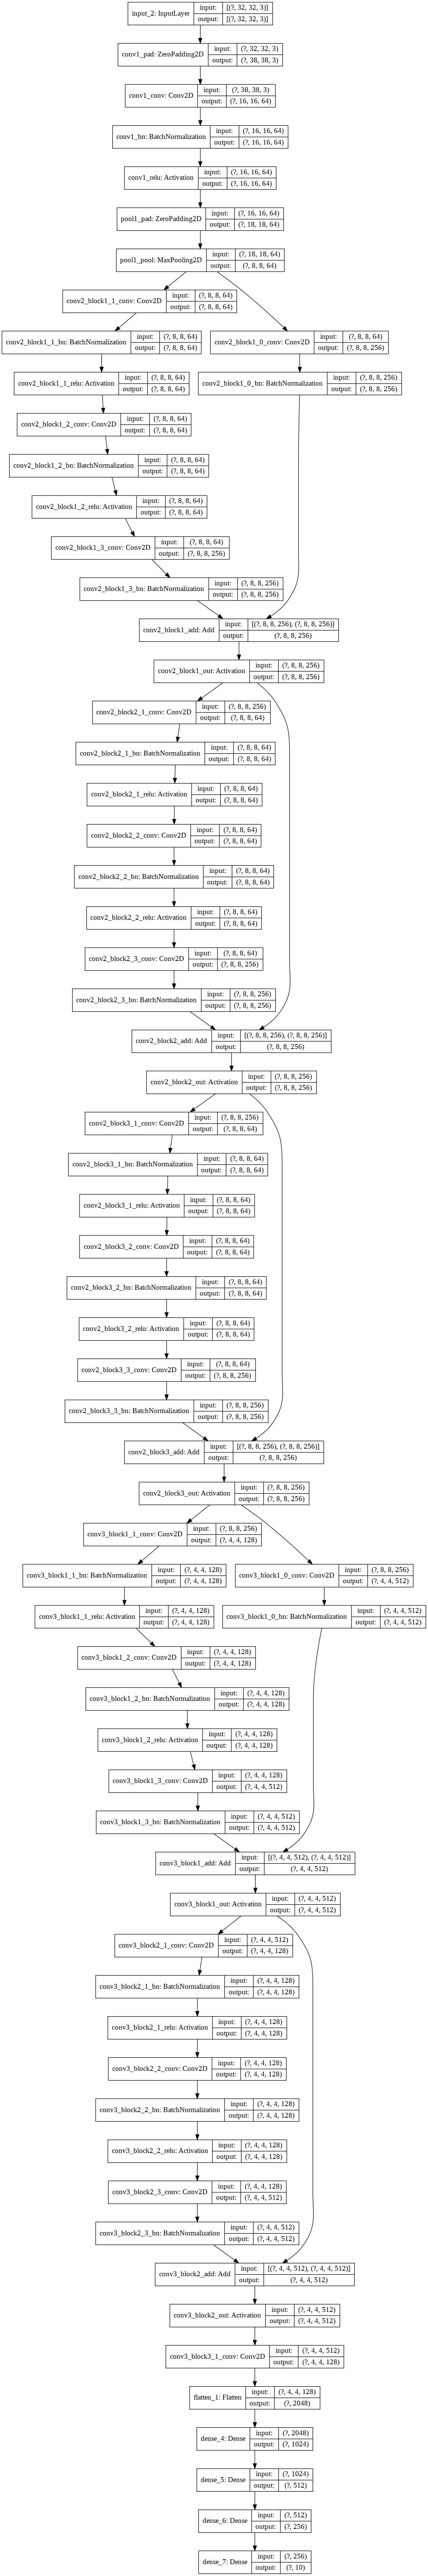

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name =path+'/resnet_relu_8_Nov 3' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-{acc:.5f}-{val_acc:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint]

In [ ]:
filepath

'/content/drive/My Drive/Environmental/resnet_relu_8_Nov 3/model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-{acc:.5f}-{val_acc:.5f}.h5'

In [ ]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/300
753/757 [============================>.] - ETA: 0s - loss: 1.2762 - acc: 0.5381
Epoch 00001: val_acc improved from -inf to 0.11268, saving model to /content/drive/My Drive/Environmental/resnet_relu_8_Nov 3/model-00001-1.27439-5.41930-0.53874-0.11268.h5
757/757 [==============================] - 10s 14ms/step - loss: 1.2744 - acc: 0.5387 - val_loss: 5.4193 - val_acc: 0.1127
Epoch 2/300
755/757 [============================>.] - ETA: 0s - loss: 0.8294 - acc: 0.7028
Epoch 00002: val_acc improved from 0.11268 to 0.50704, saving model to /content/drive/My Drive/Environmental/resnet_relu_8_Nov 3/model-00002-0.82931-1.73168-0.70283-0.50704.h5
757/757 [==============================] - 10s 14ms/step - loss: 0.8293 - acc: 0.7028 - val_loss: 1.7317 - val_acc: 0.5070
Epoch 3/300
754/757 [============================>.] - ETA: 0s - loss: 0.6480 - acc: 0.7678
Epoch 00003: val_acc did not improve from 0.50704
757/757 [==============================] - 10s 13ms/step - loss: 0.6473 - acc: 

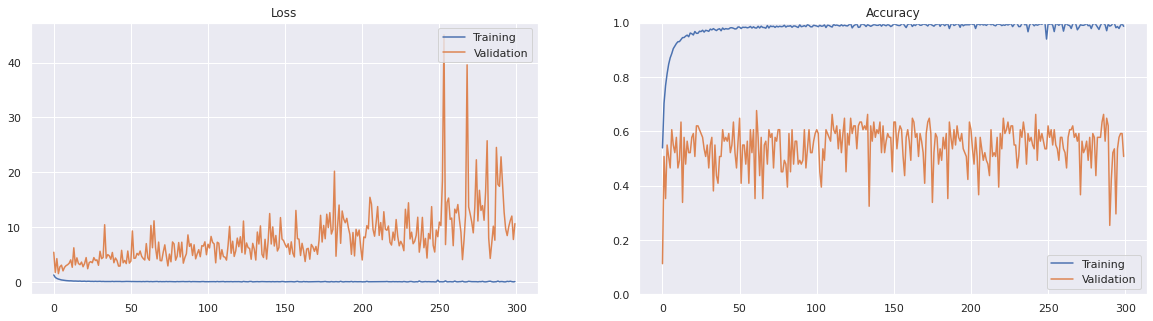

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.set_figwidth(20)
fig1.set_figheight(5)

#fig1.suptitle('Model 3 Conv 3D Performance No Pre Processing')
ax1.plot(history.history['loss'],label='Training')
ax1.plot(history.history['val_loss'],label='Validation')
ax1.set_title('Loss')
#ax1.set_ylim(0, 3)
ax1.legend(loc="upper right")

ax2.plot(history.history['acc'],label='Training')
ax2.plot(history.history['val_acc'],label='Validation')
ax2.set_title('Accuracy')
ax2.set_ylim(0.0, 1)
ax2.legend(loc="lower right")

In [ ]:
resnet_114_multi=pd.DataFrame(list(zip(history.history['acc'],history.history['val_acc'],
history.history['loss'],history.history['val_loss'])),columns =['Acc1', 'Val_Acc1','Loss1','Val_loss1'])

In [ ]:
resnet_114_multi.to_csv(path+'/resnet_relu_8_Nov 3/resnet_multi.csv')